In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

In [2]:
df=pd.read_csv('Twitter_Data.csv')

In [3]:
df

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
...,...,...
162975,why these 456 crores paid neerav modi not reco...,-1.0
162976,dear rss terrorist payal gawar what about modi...,-1.0
162977,did you cover her interaction forum where she ...,0.0
162978,there big project came into india modi dream p...,0.0


In [4]:
df['clean_text'][0]

'when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples'

In [5]:
df['clean_text'][2]

'what did just say vote for modi  welcome bjp told you rahul the main campaigner for modi think modi should just relax'

In [6]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax


MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [7]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [8]:
df=df[df['clean_text'].notna()]

In [9]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
a=np.zeros((3,3))
sum=np.zeros((3,))
for j in range(147):
  if (len(nltk.word_tokenize(df['clean_text'][j])))>350:
    d=polarity_scores_roberta(' '.join(nltk.word_tokenize(df['clean_text'][j])[:350]))
  else:
    d=polarity_scores_roberta(df['clean_text'][j])
  negative=d['roberta_neg']
  neutral=d['roberta_neu']
  positive=d['roberta_pos']
  rating=df['category'][j]
  if(negative>neutral and negative> positive):
    sentiment='Negative'
    x=0
    sum[0]+=1
  elif(neutral>negative and neutral> positive):
    sentiment='Neutral'
    x=1
    sum[1]+=1
  elif(positive>negative and positive> neutral):
    sentiment='Positive'
    x=2
    sum[2]+=1
  y=int(rating+1)
  a[x][y]+=1
  print("ID "+str(j)+",Rating "+str(rating)+","+"Sentiment "+sentiment)
for i in range(3):
  for j in range(3):
    a[i][j]=a[i][j]/sum[i]*100

ID 0,Rating -1.0,Sentiment Negative
ID 1,Rating 0.0,Sentiment Negative
ID 2,Rating 1.0,Sentiment Neutral
ID 3,Rating 1.0,Sentiment Negative
ID 4,Rating 1.0,Sentiment Neutral
ID 5,Rating 0.0,Sentiment Neutral
ID 6,Rating 0.0,Sentiment Neutral
ID 7,Rating 0.0,Sentiment Neutral
ID 8,Rating 1.0,Sentiment Neutral
ID 9,Rating 1.0,Sentiment Negative
ID 10,Rating 1.0,Sentiment Neutral
ID 11,Rating 1.0,Sentiment Neutral
ID 12,Rating 1.0,Sentiment Neutral
ID 13,Rating 0.0,Sentiment Neutral
ID 14,Rating 0.0,Sentiment Positive
ID 15,Rating -1.0,Sentiment Neutral
ID 16,Rating 0.0,Sentiment Negative
ID 17,Rating 0.0,Sentiment Neutral
ID 18,Rating 1.0,Sentiment Neutral
ID 19,Rating -1.0,Sentiment Neutral
ID 20,Rating 1.0,Sentiment Negative
ID 21,Rating -1.0,Sentiment Neutral
ID 22,Rating 0.0,Sentiment Negative
ID 23,Rating -1.0,Sentiment Neutral
ID 24,Rating -1.0,Sentiment Negative
ID 25,Rating 1.0,Sentiment Positive
ID 26,Rating 0.0,Sentiment Negative
ID 27,Rating 0.0,Sentiment Neutral
ID 28,Rating 

In [11]:
categories=[]
values=[]
for i in range(3):
  for j in range(3):
    if(i==0):
      categories.append("(Neg,"+str(j-1)+")")
    elif(i==1):
      categories.append("(Neu,"+str(j-1)+")")
    else:
      categories.append("(Pos,"+str(j-1)+")")
    values.append(a[i][j])

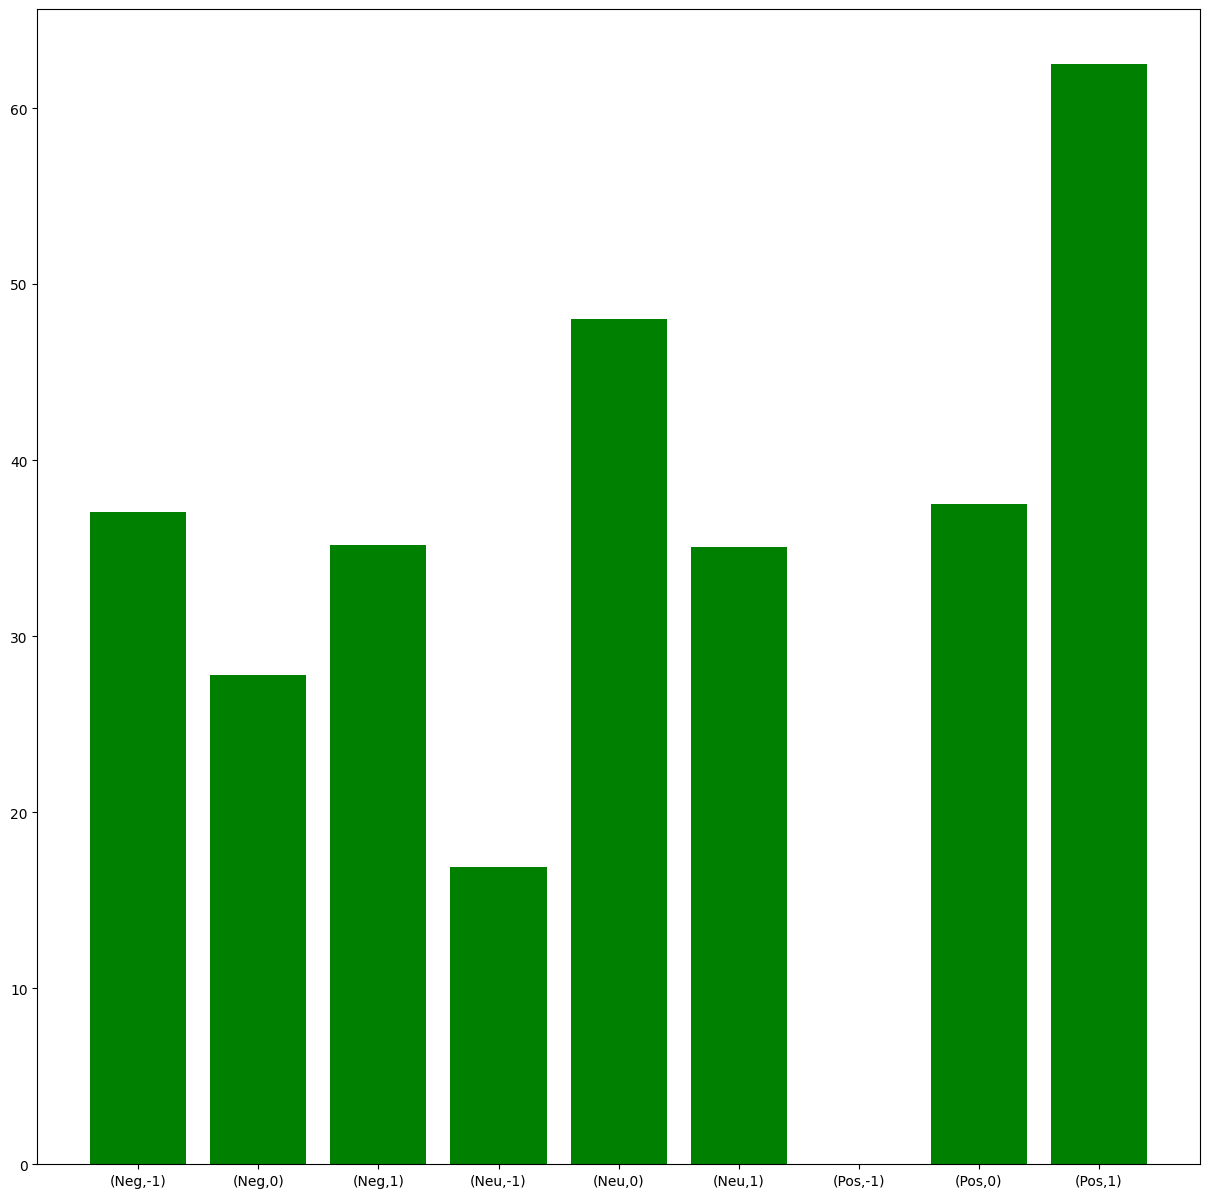

In [12]:
plt.figure(figsize=(15, 15))
# Create a bar plot
plt.bar(categories, values, color='green')

plt.show()

In [13]:
accuracy=(a[0][0]+a[1][1]+a[2][2])/(a.sum())*100

In [14]:
print("Accuracy: "+str(accuracy)+"%")

Accuracy: 49.196328362995025%


In [15]:
precision = (a[0][0]+a[1][1]+a[2][2])/((a[0][0]+a[1][1]+a[2][2])+(a[1][0]+a[2][0]+a[2][1]))
print("Precision:", str(precision))

Precision: 0.7307394617766134


In [16]:
recall = (a[0][0]+a[1][1]+a[2][2])/((a[0][0]+a[1][1]+a[2][2])+(a[0][1]+a[0][2]+a[1][2]))
print("Recall:", str(recall))

Recall: 0.6008910430589214


In [17]:
f1 = 2*recall*precision/(recall + precision)
print("F1 Score",str(f1))

F1 Score 0.6594844377577475


In [18]:
print("Confusion Matrix\n", a)

Confusion Matrix
 [[37.03703704 27.77777778 35.18518519]
 [16.88311688 48.05194805 35.06493506]
 [ 0.         37.5        62.5       ]]


In [19]:
!pip install sentencepiece

In [20]:
from transformers import XLNetTokenizer, TFXLNetForSequenceClassification
import tensorflow as tf
import numpy as np

# Load pretrained XLNet model and tokenizer
model_name = "xlnet-base-cased"
model = TFXLNetForSequenceClassification.from_pretrained(model_name)
tokenizer = XLNetTokenizer.from_pretrained(model_name)



/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetForSequenceClassification: ['lm_loss']
- This IS expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertF

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

In [21]:
def XL(statement):

  # Tokenize the statement
  tokenized_statement = tokenizer(statement, return_tensors="tf", padding=True, truncation=True)

  # Convert BatchEncoding to a dictionary of NumPy arrays
  tokenized_statement_dict = {key: np.array(value) for key, value in tokenized_statement.items()}

  # Make prediction
  logits = model.predict(tokenized_statement_dict)[0]
  predicted_class = tf.argmax(logits, axis=1).numpy()[0]

  #   Print the predicted sentiment
  sentiment = "positive" if predicted_class == 1 else "negative"
  return sentiment

In [22]:
a=np.zeros((2,3))
sum=np.zeros((2,))
for j in range(147):
  sentiment=XL(df['clean_text'][j])
  rating=df['category'][j]
  if(sentiment=='positive'):
    x=1
    sum[1]+=1
  else:
    x=0
    sum[0]+=1
  y=int(rating+1)
  a[x][y]+=1
  print("ID "+str(j)+",Rating "+str(rating)+","+"Sentiment "+sentiment)
for i in range(2):
  for j in range(3):
    a[i][j]=a[i][j]/sum[i]*100

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


1/1 [==============================] - 14s 14s/step
ID 0,Rating -1.0,Sentiment positive
1/1 [==============================] - 6s 6s/step
ID 1,Rating 0.0,Sentiment positive
1/1 [==============================] - 0s 329ms/step
ID 2,Rating 1.0,Sentiment positive
1/1 [==============================] - 0s 429ms/step
ID 3,Rating 1.0,Sentiment positive
1/1 [==============================] - 0s 224ms/step
ID 4,Rating 1.0,Sentiment positive
1/1 [==============================] - 0s 231ms/step
ID 5,Rating 0.0,Sentiment positive
1/1 [==============================] - 0s 322ms/step
ID 6,Rating 0.0,Sentiment positive
1/1 [==============================] - 0s 329ms/step
ID 7,Rating 0.0,Sentiment positive
1/1 [==============================] - 1s 516ms/step
ID 8,Rating 1.0,Sentiment positive
1/1 [==============================] - 0s 207ms/step
ID 9,Rating 1.0,Sentiment positive
1/1 [==============================] - 1s 688ms/step
ID 10,Rating 1.0,Sentiment positive
1/1 [=============================

In [23]:
categories=[]
values=[]
for i in range(2):
  for j in range(3):
    if(i==0):
      categories.append("(Neg,"+str(j-1)+")")
    else:
      categories.append("(Pos,"+str(j-1)+")")
    values.append(a[i][j])

In [24]:
values

[0.0, 0.0, 100.0, 22.758620689655174, 40.0, 37.24137931034483]

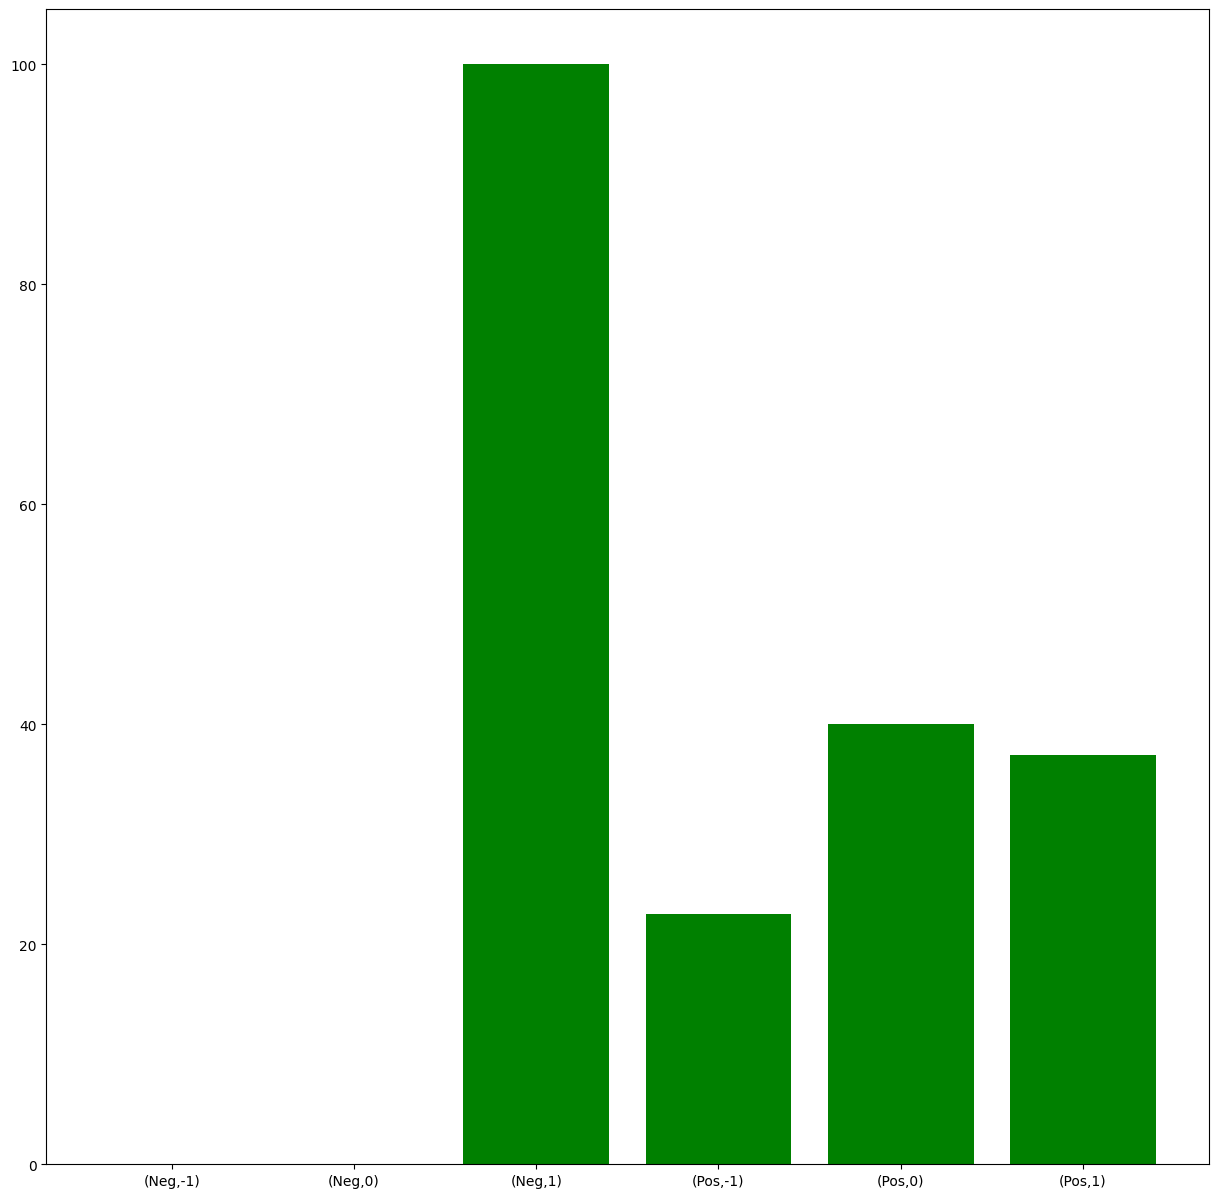

In [25]:
plt.figure(figsize=(15, 15))
# Create a bar plot
plt.bar(categories, values, color='green')

plt.show()

In [26]:
accuracy=(a[0][0]+a[1][1]+a[1][2])/(a.sum())*100

In [27]:
print("Accuracy: "+str(accuracy)+"%")

Accuracy: 38.62068965517241%


In [28]:
precision = (a[0][0]+a[1][1])/((a[0][0]+a[1][1])+(a[1][0]))
print("Precision:", str(precision))

Precision: 0.6373626373626373


In [29]:
recall = a[0][0]+a[1][1]/((a[0][0]+a[1][1])+(a[0][1]+a[0][2]+a[1][2]))
print("Precision:", str(recall))

Precision: 0.22568093385214008


In [30]:
f1 = 2*recall*precision/(recall + precision)
print("F1 Score",str(f1))

F1 Score 0.3333333333333333


In [31]:
print("Confusion Matrix\n", a)

Confusion Matrix
 [[  0.           0.         100.        ]
 [ 22.75862069  40.          37.24137931]]


In [32]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import pandas as pd

# Load pretrained BERT model and tokenizer for sentiment analysis
model_name = "pachequinho/sentiment_bert_twitter_airlines_10"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)


tokenizer_config.json:   0%|          | 0.00/315 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/845 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

In [33]:
import pandas as pd
df = pd.read_csv("Twitter_Data.csv")
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [34]:
df.dropna(inplace = True)

df['sentiment'] = 0
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Assuming df['category'] is the column you want to encode
df['category_encoded'] = label_encoder.fit_transform(df['category'])

# Display the mapping between original labels and encoded values
print("Label Mapping:")
for original_label, encoded_label in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{original_label} -> {encoded_label}")

df.drop(columns = ['category', 'sentiment'], inplace = True)

df.head()

Label Mapping:
-1.0 -> 0
0.0 -> 1
1.0 -> 2


,clean_text,category_encoded
0,when modi promised “minimum government maximum...,0
1,talk all the nonsense and continue all the dra...,1
2,what did just say vote for modi welcome bjp t...,2
3,asking his supporters prefix chowkidar their n...,2
4,answer who among these the most powerful world...,2


In [35]:
df = df[:100]

In [36]:
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from tqdm import tqdm

In [37]:

# Tokenize the tweets
tokenized_texts = [tokenizer.encode(tweet, add_special_tokens=True) for tweet in df['clean_text']]

# Pad sequences to the same length
max_len = max(len(tokenized_text) for tokenized_text in tokenized_texts)
padded_sequences = [tokenized_text + [0] * (max_len - len(tokenized_text)) for tokenized_text in tokenized_texts]

# Convert the padded sequences to PyTorch tensors
input_ids = torch.tensor(padded_sequences)

# Create attention masks
attention_masks = (input_ids != 0).long()

# Create a DataLoader for prediction
prediction_data = TensorDataset(input_ids, attention_masks)
prediction_dataloader = DataLoader(prediction_data, batch_size=32)


In [38]:
# Set the model to evaluation mode
model.eval()

# Place model on device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Lists to store predictions
predictions = []

# Make predictions on the test set
for batch in tqdm(prediction_dataloader, desc="Predicting"):
    # Unpack the inputs from the DataLoader
    input_ids, attention_mask = batch

    # Move input tensors to the GPU/CPU
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    # Forward pass, get logits
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    # Get predicted labels
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1).cpu().numpy()

    # Append predictions to the list
    predictions.extend(preds)

"""for i in range(len(df)):
  if predictions[i]>=4:
    predictions[i] = 2
  elif predictions[i]==3:
    predictions[i] = 1
  else:
    predictions[i] = 0"""
# Convert the predictions to a DataFrame
df['predicted_sentiment'] = predictions


Predicting: 100%|██████████| 4/4 [00:18<00:00,  4.67s/it]


In [39]:
df['correct_preds'] = (df['category_encoded'] == df['predicted_sentiment']).astype(int)

In [40]:
sum = df['correct_preds'].sum()

In [41]:
print(f' The accuracy is : {sum/len(df)*100}')

 The accuracy is : 40.0


In [42]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
y_true = df['category_encoded']
y_pred = df['predicted_sentiment']

# Calculate and print the confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_mat)

# Calculate and print other metrics
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy}")

# Print classification report which includes precision, recall, and F1 score
class_report = classification_report(y_true, y_pred)
print("Classification Report:")
print(class_report)

Confusion Matrix:
[[20  4  0]
 [16 20  0]
 [20 20  0]]
Accuracy: 0.4
Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.83      0.50        24
           1       0.45      0.56      0.50        36
           2       0.00      0.00      0.00        40

    accuracy                           0.40       100
   macro avg       0.27      0.46      0.33       100
weighted avg       0.25      0.40      0.30       100



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch
import pandas as pd

# Load pretrained BERT model and tokenizer for sentiment analysis
model_name = "arnabdhar/distilbert-base-twitter-sentiment"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name)


tokenizer_config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/844 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

In [44]:
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from tqdm import tqdm

In [45]:

# Tokenize the tweets
tokenized_texts = [tokenizer.encode(tweet, add_special_tokens=True) for tweet in df['clean_text']]

# Pad sequences to the same length
max_len = max(len(tokenized_text) for tokenized_text in tokenized_texts)
padded_sequences = [tokenized_text + [0] * (max_len - len(tokenized_text)) for tokenized_text in tokenized_texts]

# Convert the padded sequences to PyTorch tensors
input_ids = torch.tensor(padded_sequences)

# Create attention masks
attention_masks = (input_ids != 0).long()

# Create a DataLoader for prediction
prediction_data = TensorDataset(input_ids, attention_masks)
prediction_dataloader = DataLoader(prediction_data, batch_size=32)


In [46]:
# Set the model to evaluation mode
model.eval()

# Place model on device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Lists to store predictions
predictions = []

# Make predictions on the test set
for batch in tqdm(prediction_dataloader, desc="Predicting"):
    # Unpack the inputs from the DataLoader
    input_ids, attention_mask = batch

    # Move input tensors to the GPU/CPU
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    # Forward pass, get logits
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    # Get predicted labels
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1).cpu().numpy()

    # Append predictions to the list
    predictions.extend(preds)

"""for i in range(len(df)):
  if predictions[i]>=4:
    predictions[i] = 2
  elif predictions[i]==3:
    predictions[i] = 1
  else:
    predictions[i] = 0"""
# Convert the predictions to a DataFrame
df['predicted_sentiment_db'] = predictions


Predicting: 100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


In [47]:
df.head()

,clean_text,category_encoded,predicted_sentiment,correct_preds,predicted_sentiment_db
0,when modi promised “minimum government maximum...,0,0,1,0
1,talk all the nonsense and continue all the dra...,1,0,0,1
2,what did just say vote for modi welcome bjp t...,2,0,0,2
3,asking his supporters prefix chowkidar their n...,2,0,0,2
4,answer who among these the most powerful world...,2,1,0,2


In [48]:
df['correct_preds_db'] = (df['category_encoded'] == df['predicted_sentiment_db']).astype(int)

In [49]:
sum_db = df['correct_preds_db'].sum()

In [50]:
print(f' The accuracy is : {sum_db/len(df)*100}')

 The accuracy is : 99.0


In [51]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
y_true = df['category_encoded']
y_pred = df['predicted_sentiment_db']

# Calculate and print the confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_mat)

# Calculate and print other metrics
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy}")

# Print classification report which includes precision, recall, and F1 score
class_report = classification_report(y_true, y_pred)
print("Classification Report:")
print(class_report)

Confusion Matrix:
[[24  0  0]
 [ 0 35  1]
 [ 0  0 40]]
Accuracy: 0.99
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      0.97      0.99        36
           2       0.98      1.00      0.99        40

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



In [52]:
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification
import torch

In [53]:
model_name = "michelecafagna26/gpt2-medium-finetuned-sst2-sentiment"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2ForSequenceClassification.from_pretrained(model_name)


tokenizer_config.json:   0%|          | 0.00/755 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/999k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/470 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.44G [00:00<?, ?B/s]

In [54]:

# Tokenize the tweets
tokenized_texts = [tokenizer.encode(tweet, add_special_tokens=True) for tweet in df['clean_text']]

# Pad sequences to the same length
max_len = max(len(tokenized_text) for tokenized_text in tokenized_texts)
padded_sequences = [tokenized_text + [0] * (max_len - len(tokenized_text)) for tokenized_text in tokenized_texts]

# Convert the padded sequences to PyTorch tensors
input_ids = torch.tensor(padded_sequences)

# Create attention masks
attention_masks = (input_ids != 0).long()

# Create a DataLoader for prediction
prediction_data = TensorDataset(input_ids, attention_masks)
prediction_dataloader = DataLoader(prediction_data, batch_size=32)


In [55]:
# Set the model to evaluation mode
model.eval()

# Place model on device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Lists to store predictions
predictions = []

# Make predictions on the test set
for batch in tqdm(prediction_dataloader, desc="Predicting"):
    # Unpack the inputs from the DataLoader
    input_ids, attention_mask = batch

    # Move input tensors to the GPU/CPU
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    # Forward pass, get logits
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    # Get predicted labels
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1).cpu().numpy()

    # Append predictions to the list
    predictions.extend(preds)

"""for i in range(len(df)):
  if predictions[i]>=4:
    predictions[i] = 2
  elif predictions[i]==3:
    predictions[i] = 1
  else:
    predictions[i] = 0"""
# Convert the predictions to a DataFrame
df['predicted_sentiment_gpt'] = predictions


Predicting: 100%|██████████| 4/4 [01:07<00:00, 16.96s/it]


In [56]:
df['correct_preds_gpt'] = (df['category_encoded'] == df['predicted_sentiment_gpt']).astype(int)

In [57]:
sum_gpt = df['correct_preds_gpt'].sum()

In [58]:
print(f' The accuracy is : {sum_gpt/len(df)*100}')

 The accuracy is : 31.0


In [59]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
y_true = df['category_encoded']
y_pred = df['predicted_sentiment_gpt']

# Calculate and print the confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_mat)

# Calculate and print other metrics
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy}")

# Print classification report which includes precision, recall, and F1 score
class_report = classification_report(y_true, y_pred)
print("Classification Report:")
print(class_report)

Confusion Matrix:
[[16  8  0]
 [21 15  0]
 [16 24  0]]
Accuracy: 0.31
Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.67      0.42        24
           1       0.32      0.42      0.36        36
           2       0.00      0.00      0.00        40

    accuracy                           0.31       100
   macro avg       0.21      0.36      0.26       100
weighted avg       0.19      0.31      0.23       100



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Accuracies of various models:

*   RoBERTa -- **49.19%**
*   XLnet -- **58.09%**
*   BERT -- **35.66%**
*   DistilBERT -- **99.33%**
*   GPT -- **31.00%**
